In [93]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt



class RamanSpectrum:
    """
    A Class to perform ploting, cutting spectrums in a certain range
    denoise, baseline and multipeak fit. It needs the path of a 
    RamanSpectrum of type txt. It should be noted that the format of this txt 
    may be different for an observation made in another device. But in general the main
    part is inside the x,y pairs so the read of another type of format can be modified to
    provide x, and yas an np array in the initialization method.
    """

    def __init__(self, filepath, x=None,y=None):
        # Read in the data from the file or reading the x, y values

        with open(filepath, 'r', encoding='iso-8859-1') as f:
            lines = f.readlines()
        
        # Extract the metadata from the file
        self.metadata = {}
        # Creating an empty dictionary to store the coordinates
        self.dictcoords = {}

        for line in lines:
            if line.startswith("#"):
                # Storing the metadata
                key, value = line.strip().split("=")
                self.metadata[key[1:]] = value.replace('\t', '')
        
        # Now that we have the metadata stored in a dictionary, we can
        # store the value of the keys in a set of strings

        self.metakeys = self.metadata.keys()
        
        # Extract the x and y data from the file
        
        self.data = np.loadtxt(lines[len(self.metadata):])
        self.x = self.data[:,0]
        self.y = self.data[:,1]

        self.sample = self.metadata['Acquired'].replace(' ', '_')

        # Creating a folder to store the data
        if not os.path.exists(self.sample):
            os.makedirs(self.sample)
        
        # Saving the data as an dictionary
        for e in self.data:
            self.dictcoords[e[0]] = e[1]
    
    def plot(self):
        """Plotting the data"""
        plt.plot(self.x, self.y)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.show()

    def acces_value(self, pattern):
        matched_keys = set()
        regex = re.compile(pattern, re.IGNORECASE)
        for key in self.metakeys:
            if regex.search(key):
                matched_keys.add(key)
        return (matched_keys, [self.metadata[key] for key in matched_keys])
    
    def crop(self, lower, upper, show = False):
        """
        This method crops the x and y values to only a subset of the 
        original points. It also plots the cropped data if the show
        parameter is set to True. Always saves the cropped data as an
        image.
        """
        self.croppedx = []
        self.croppedy = []
        for e in self.x:
            if e > lower and e < upper:
                self.croppedx.append(e)
                self.croppedy.append(self.dictcoords[e])
        plt.plot(self.croppedx, self.croppedy)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title(self.metadata['Date'])
        # Saving the cropped data as an image

        if not os.path.exists(self.sample+'/cropped'):
            os.makedirs(self.sample+'/cropped')

        name = self.sample+"/cropped/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()
    
    def polifit(self, a,b,ord = 3):
        """
        a is the lowest value of the x pairs and b
        is the highest value. ord is the order of the polynomial
        to be fitted
        """
        
        x = []
        y = []
        for x_i, y_i in zip(self.croppedx,self.croppedy):
            if x_i < a or x_i > b:
                x.append(x_i)
                y.append(y_i)
        # Fitting the data
        fitted = np.polyfit(x, y, ord)
        self.fitted = fitted
        # Plotting the first part
        plt.subplot(2, 1, 1)  # Create subplot 1
        plt.plot(self.croppedx, self.croppedy)
        plt.plot(self.croppedx, np.polyval(fitted, self.croppedx))
        plt.xlim(min(self.croppedx), max(self.croppedx))
        ef = abs(max(self.croppedy) - min(self.croppedy))/20
        plt.ylim(min(self.croppedy)-ef, max(self.croppedy)+ef)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('With baseline')
        # Plotting the second part
        plt.subplot(2, 1, 2)  # Create subplot 2
        plt.plot(self.croppedx, self.croppedy - np.polyval(fitted, self.croppedx))
        self.polylx = self.croppedx
        self.polyly = self.croppedy - np.polyval(fitted, self.croppedx)
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Without baseline')

        # Saving both plots in the same file
        if not os.path.exists(self.sample+'/polyfit'):
            os.makedirs(self.sample+'/polyfit')
        plt.savefig(self.sample+"/polyfit/{i}.png".format(i=self.metadata['Date']))
        plt.subplots_adjust(hspace=1)
        plt.show()
    
    def sav_gol(self, window, order, x_arr,y_arr, show=False):
        """
        Takes the x and y values and applies a Savitzky-Golay filter
        sets self.denoisedx and self.denoisedy to the denoised values
        """
        self.denoisedx = []
        self.denoisedy = []    
        self.savgol = savgol_filter(y_arr, window, order)
        self.denoisedx = x_arr
        self.denoisedy = self.savgol
        plt.plot(self.denoisedx, self.denoisedy)
        self.basedx = self.denoisedx
        self.basedy = self.denoisedy
        plt.xlabel("Wavenumber (cm$^{-1}$)")
        plt.ylabel("Intensity (counts)")
        plt.title('Denoised')

        if not os.path.exists(self.sample+'/denoised'):
            os.makedirs(self.sample+'/denoised')

        # Saving the cropped data as an image
        name = self.sample + "/denoised/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        if show:
            plt.show()
        plt.clf()

    def baseline(self,degree = 1, show = False, before=False):
        # Fit polynomial baseline

        xfit = self.denoisedx[:5] + self.denoisedx[-5:]
        self.a = list(self.denoisedy[:5])
        self.b = list(self.denoisedy[-5:])
        
        print(self.a)
        print(self.b)

        yfit = self.a + self.b
        print(type(self.denoisedx),type(self.denoisedy))
        print('The lenghts',len(xfit),len(yfit))

        coefficients = np.polyfit(xfit, yfit, degree)
        baseline = np.polyval(coefficients, self.denoisedx)

        # Plot the original signal and the baseline
        # plt.plot(self.denoisedx, self.denoisedy, label='Original Signal')
        new_zero = abs(min(self.denoisedy - baseline))
        if before:
            plt.plot(self.denoisedx, (self.croppedy + new_zero)  , label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        else:
            plt.plot(self.denoisedx, (self.denoisedy + new_zero), label='baselined')
            plt.plot(self.denoisedx, baseline, label='Baseline')
        self.basedx = self.denoisedx
        self.basedy = (self.denoisedy + new_zero) - baseline
        # plt.plot(self.denoisedx, baseline, label='Baseline')
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Intensity (counts)')

        if not os.path.exists(self.sample+'/baseline'):
            os.makedirs(self.sample+'/baseline')

        plt.title(self.metadata['Date'] + ' - Baseline')
        if show:
            plt.show()
        name = self.sample + "/baseline/{i}.png".format(i = self.metadata['Date'])
        plt.savefig(name)
        plt.clf()
    

    # Define the function as the sum of three Gaussian curves
    def gaussian(self, x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

    def multi_peak_fit(self, x, *params):
        num_peaks = len(params) // 3
        y_fit = np.zeros_like(x)

        for i in range(num_peaks):
            amplitude, center, sigma = params[i*3 : (i+1)*3]
            y_fit += self.gaussian(x, amplitude, center, sigma)
        return y_fit
    
    def normalized(self, m = 0, raw=True):
        if raw:
            ymin = min(self.croppedy)
            y = self.croppedy - ymin
            ymax = max(y)
            return self.croppedx, (((y)/ymax)+m)
    
    def get_fitting(self,f1,f2,f3,f4,f5,c1,c2,c3,c4,c5,s1,s2,s3,s4,s5,xy, show = False, mode = ''):
        if(mode=='cropped'):
            x = np.array(self.croppedx)
            y = np.array(self.croppedy)
        elif(mode=='xy'):
            x = np.array(xy[0])
            y = np.array(xy[1])
        else:
            x = 0
            y = 0

        yspec = max(y)
        
        yspec1 = yspec*f1
        yspec2 = yspec*f2
        yspec3 = yspec*f3
        yspec4 = yspec*f4
        yspec5 = yspec*f5

        # Perform the multi-peak fitting
        # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
        initial_guess = [yspec5, c5, s5, yspec4, c4, s4, yspec3, c3, s3, yspec2, c2, s2, yspec1, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
        if not os.path.exists(self.sample+'/fit'):
                os.makedirs(self.sample+'/fit')

        popt, pcov = curve_fit(self.multi_peak_fit, x, y, p0=initial_guess)

        # Extract the optimized parameters
        amplitudes = popt[0::3]
        centers = popt[1::3]
        sigmas = popt[2::3]

        for i in range(0,3):
            amp,cen,sig = popt[i*3:(i+1)*3]

        self.fit_props = popt

        # Print the results

        print('Amplitudes: {}'.format(amplitudes))
        print('Centers: {}'.format(centers))
        print('Sigmas: {}'.format(sigmas))

        # Generate the fitted curve
        x_fit = np.linspace(x.min(), x.max(), 1000)
        y_fit = self.multi_peak_fit(x_fit, *popt)
        # Plot the original data and the fitted curve
        plt.plot(x, y, 'bo', label='Original Data')
        plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
        self.x_fit = x_fit
        self.y_fit = y_fit
        plt.legend()
        plt.xlabel('wavenumber (cm$^{-1}$)')
        plt.ylabel('Counts (a.u.)')
        if show:
            plt.show()
        plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
        self.popt = popt
        plt.clf()

    # def get_fitting(self, x_,y_, f2 = 0.5, f3 = 0.3 , c1 = 520, c2 = 500, c3 = 480, s1 = 10, s2 = 20, s3 = 40 ,show = False):
    #     """
    #     A multi-peak fitting function that takes the x and y values and fits them to a multi-peak function
    #     """
    #     x = np.array(x_)
    #     y = np.array(y_ + abs(min(y_)))

    #     yspec = max(y)
    #     yspec2 = yspec*f2
    #     yspec3 = yspec*f3

    #     # Perform the multi-peak fitting
    #     # initial_guess = [yspec3, 450, 100, yspec2, 510, 10, yspec, 520, 10]
    #     initial_guess = [yspec3, c3, s3, yspec2, c2, s2, yspec, c1, s1]   # Initial guess for parameters: [amplitude1, center1, sigma1, amplitude2, center2, sigma2, amplitude3, center3, sigma3]
        
    #     if not os.path.exists(self.sample):
    #         os.makedirs(self.sample+'/fit')
        
    #     amplitudes = popt[0::3]
    #     centers = popt[1::3]
    #     sigmas = popt[2::3]

    #     # Print the results

    #     print('Amplitudes: {}'.format(amplitudes))
    #     print('Centers: {}'.format(centers))
    #     print('Sigmas: {}'.format(sigmas))

    #     # Generate the fitted curve
    #     x_fit = np.linspace(x.min(), x.max(), 1000)
    #     y_fit = self.multi_peak_fit(x_fit, *popt)
    #     # Plot the original data and the fitted curve
    #     plt.plot(x, y, 'bo', label='Original Data')
    #     plt.plot(x_fit, y_fit, 'r-', label='Fitted Curve')
    #     plt.legend()
    #     plt.xlabel('x')
    #     plt.ylabel('y')
    #     if show:
    #         plt.show()
    #     plt.savefig(self.sample+'/fit/{}.png'.format(self.metadata['Date']))
    #     plt.clf()



In [95]:
import os

path = "espectrosraman/"
extetion = ".txt"
files = []

for r, d, f in os.walk(path):
    for file in f:
        if extetion in file:
            files.append(r+'/'+file)

files

['espectrosraman//In2S3-5_5_15 - verde.txt',
 'espectrosraman//In2S3-_5_5_03.txt',
 'espectrosraman//In2S3_CdS-367-633_02.txt',
 'espectrosraman//In2S3_CdS-367_03.txt',
 'espectrosraman//In2S3_CdS-370-633_01.txt',
 'espectrosraman//In2S3_CdS-370_01.txt',
 'espectrosraman//ZnO-In2S3-CdS-10_1_04.txt',
 'espectrosraman//ZnO-In2S3-CdS-10_1_06.txt']

In [96]:
r = RamanSpectrum(files[0])
r.metadata

{'Acq. time (s)': '20',
 'Accumulations': '10',
 'Range (cm-¹)': '50...450',
 'Windows': '1',
 'Autofocus': 'Off',
 'AutoExposure': 'Off',
 'Spike filter': 'Multiple accum.',
 'Delay time (s)': '0',
 'Binning': '1',
 'Readout mode': 'Signal',
 'DeNoise': 'Off',
 'ICS correction': 'Off',
 'Dark correction': 'Off',
 'Inst. Process': 'Off',
 'Instrument': 'LabRAM HR Evol',
 'Detector': 'Syncerity OE',
 'Objective': 'x100_VIS_LWD',
 'Grating': '600 (500nm)',
 'ND Filter': '50%',
 'Laser': '532nm_Edge',
 'Hole': '349.983',
 'Range': 'Visible',
 'Project': 'Antony',
 'Sample': '',
 'Site': '30-03-23',
 'Title': 'In2S3-5_5',
 'Remark': '',
 'Date': '30.03.2023 19:43',
 'Acquired': '30.03.2023 19:43:58'}

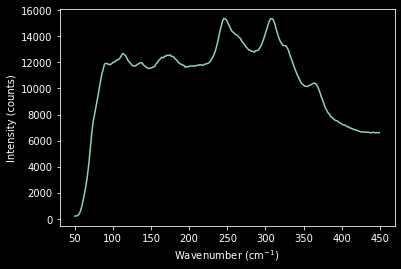

In [97]:
r.plot()

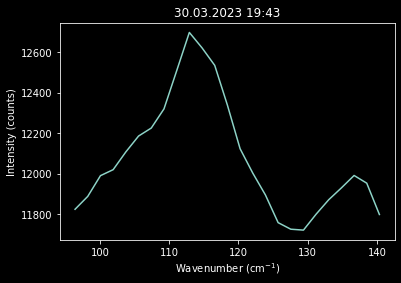

<Figure size 432x288 with 0 Axes>

In [98]:
r.crop(96,142, show =True)

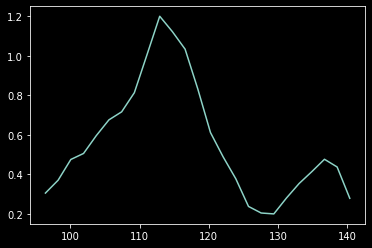

In [99]:
x_, y_ = r.normalized(m = 0.2)
plt.plot(x_,y_)

In [100]:
r.get_fitting(f1 = 0.3, f2 = 0.4, f3 = 1 , f4=0.4 , f5=0.2, c1 = 139, c2 = 124, c3 = 115, c4=108, c5= 100, s1 = 12, s2 = 10, s3 = 12, s4=8, s5=5 ,xy = [x_,y_], mode ='xy', show = True)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 3200.

In [50]:
def gaussian(x, amplitude, center, sigma):
        return amplitude * np.exp(-(x - center)**2 / (2 * sigma**2))

6802.827268520686 86.0635986956494 7.0596961772106965
-212.13050734602876 102.60863053179123 1.8164889472622503
-847.7134059980898 107.99603776208009 3.404604612823138
9942.141819155282 104.50005255414982 13.290237728331187
11613.882567163415 140.66258830295678 20.917724974655282
######## 

######## 

######## 

######## 
 
  pops
-212.13050734602876 [ 6.80282727e+03  8.60635987e+01  7.05969618e+00 -2.12130507e+02
  1.02608631e+02  1.81648895e+00 -8.47713406e+02  1.07996038e+02
  3.40460461e+00  9.94214182e+03  1.04500053e+02  1.32902377e+01
  1.16138826e+04  1.40662588e+02  2.09177250e+01]
False
######## 

######## 

######## 

######## 
 
  pops
-847.7134059980898 [ 6.80282727e+03  8.60635987e+01  7.05969618e+00 -2.12130507e+02
  1.02608631e+02  1.81648895e+00 -8.47713406e+02  1.07996038e+02
  3.40460461e+00  9.94214182e+03  1.04500053e+02  1.32902377e+01
  1.16138826e+04  1.40662588e+02  2.09177250e+01]
False
######## 

######## 

######## 

######## 

######## 

######## 

########

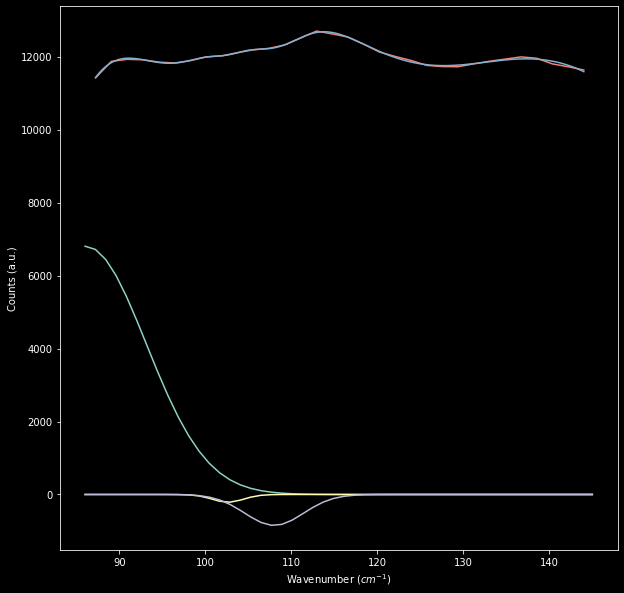

In [51]:

ob = r
g = []
gy = []

x = np.linspace(86,145)

exp_x = ob.croppedx
exp_y = ob.croppedy
fit_x = ob.x_fit
fit_y = ob.y_fit

for i in range(0,5):
    a,c,s = ob.popt[i*3:(i+1)*3]
    g.append([a,c,s])
    print(a,c,s)
    gy.append(gaussian(x,a,c,s))
plt.figure(figsize=(10,10))
plt.plot(x,gy[0])
plt.plot(x,gy[1])
plt.plot(x,gy[2])
plt.plot(exp_x,exp_y)
plt.plot(fit_x,fit_y)
plt.xlabel('Wavenumber $(cm^{-1})$')
plt.ylabel('Counts (a.u.)')
for e in ob.popt:
    if e < 0:
        print('######## \n \n  pops')
        print(e, ob.popt)
        print(ob.metadata['Acquired']=='21.03.2023 10:08:20')
    print('######## \n')
# pops_data[spec] = ob.popt
# plt.savefig('frames/'+spec+'.png')
plt.show()


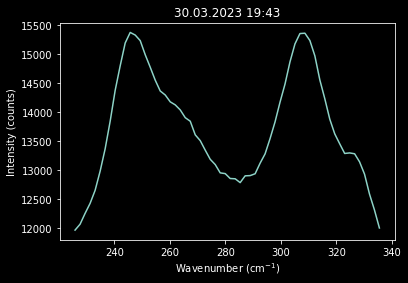

<Figure size 432x288 with 0 Axes>

In [40]:
file = files[0]
raman = RamanSpectrum(file)
raman.crop(225,336, show=True)

In [41]:
raman.metadata

{'Acq. time (s)': '20',
 'Accumulations': '10',
 'Range (cm-¹)': '50...450',
 'Windows': '1',
 'Autofocus': 'Off',
 'AutoExposure': 'Off',
 'Spike filter': 'Multiple accum.',
 'Delay time (s)': '0',
 'Binning': '1',
 'Readout mode': 'Signal',
 'DeNoise': 'Off',
 'ICS correction': 'Off',
 'Dark correction': 'Off',
 'Inst. Process': 'Off',
 'Instrument': 'LabRAM HR Evol',
 'Detector': 'Syncerity OE',
 'Objective': 'x100_VIS_LWD',
 'Grating': '600 (500nm)',
 'ND Filter': '50%',
 'Laser': '532nm_Edge',
 'Hole': '349.983',
 'Range': 'Visible',
 'Project': 'Antony',
 'Sample': '',
 'Site': '30-03-23',
 'Title': 'In2S3-5_5',
 'Remark': '',
 'Date': '30.03.2023 19:43',
 'Acquired': '30.03.2023 19:43:58'}

Amplitudes: [  571.61343813  1700.66980781 14044.95634816  6813.53831564
  7034.56688046]
Centers: [223.63052071 245.59916697 257.71863288 310.58481394 334.2400982 ]
Sigmas: [ 4.26754943  5.98326809 49.91835888 11.7063954   9.38431985]


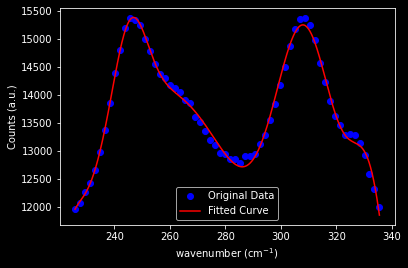

<Figure size 432x288 with 0 Axes>

In [29]:
raman.get_fitting(f1 = 0.45, f2 = 1, f3 = 0.6 , f4=1 , f5=0.2, c1 = 330, c2 = 310, c3 = 260, c4=250, c5= 224, s1 = 7, s2 = 20, s3 = 30, s4=20, s5=3 ,show = True)

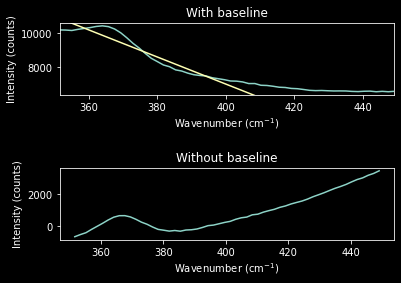

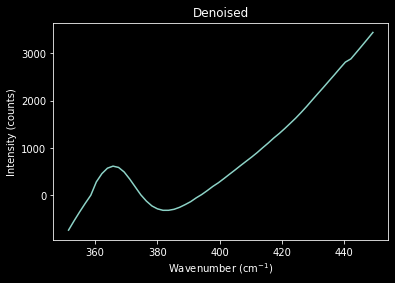

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 2000.

<Figure size 432x288 with 0 Axes>

In [3]:
stats = {}

for f in files:
    sp0 = RamanSpectrum(f)
    sp0.crop(lower=350, upper=600)
    sp0.polifit(a=400, b = 550, ord = 1)
    sp0.sav_gol(10,2,sp0.polylx,sp0.polyly,show=True)
    sp0.get_fitting(f2 = 0.7, f3 = 0.3 , c1 = 515, c2 = 500, c3 = 410, s1 = 10, s2 = 20, s3 = 70 ,show = True)
    stats[sp0.metadata['Acquired']] = (sp0.popt,sp0)